# Ways to Visualize Template Learning

Sometimes, it is good to explore how does the template reacts throughout learning phase to different inputs. As scrabble had only one learnable predicate, to showcase the exploring functionality, Visualization is showed on a bit advanced task.

## Task

We are given a figure made of $n$ cards and we should say whether the figure is straight or not. If the figure is straight, we should further output the value of the highest card in it. The problem is that the cards are heavily illustrated in an unpredictable manner and so we cannot decode neither cards' rank nor their suit. We can only distinguish when the cards are the same (have the same suit and the same rank) because they have the same illustration.

We do not know the card value nor its suit but we know that we are finding the straights. A straight depends only on the card value so we will cluster the card ids to $m$ clusters where $m$ is the number of different card values (which can be deduced, e.g., from labels in the training set). We know that a straight is built from $n$ consecutive integers so we order them in any way and add a rule for every $n$ consecutive clusters. These rules will determine the output. The corresponding neuro-logic template is then as follows

### Template

In [ ]:
%%writefile poker_rules.pl
0.0 cardFromGroup(Group,Position) :- card(Position,Rank,Suit),
                                     range(GroupRange,2,5),
                                     member(Group,GroupRange),
                                     range(RankRange,2,5),
                                     member(Rank,RankRange),
                                     member(Suit,[hearts,diamonds,clubs,spades]). [^Rank,^Suit,^Group,lukasiewicz]
<1.0> straight(SucGroup) :- cardFromGroup(Group,Position1),succ(Group,SucGroup),
                        cardFromGroup(SucGroup,Position2),@alldiff(Position1,Position2),
                        range(SucGroupRange,3,5),member(SucGroup,SucGroupRange). [^SucGroup,lukasiewicz]
<3.0> score() :- straight(3). [lukasiewicz]
<4.0> score() :- straight(4). [lukasiewicz]
<5.0> score() :- straight(5). [lukasiewicz]
<1.0> succ(0,1) :- @true(a).
<1.0> succ(1,2) :- @true(a).
<1.0> succ(2,3) :- @true(a).
<1.0> succ(3,4) :- @true(a).
<1.0> succ(4,5) :- @true(a).
score/0 [identity]

The training set consists of different figures that can be made, labeled with the value of the highest card if the figure is straight and zero otherwise.

For this particular task, traning set was generated from 78 random words.

### Training set

In [ ]:
from neurologic.common import ExampleFactory
from itertools import combinations_with_replacement
def evaluate(cards,ranks,straight_size=2):
    cards = set(cards)
    # straight combination
    for st in range(2,2+len(ranks)-straight_size+1):
        straight = set(range(st,st+straight_size))
        if not straight - cards:
            return st+straight_size-1
    return 0

def get_examples(ranks,suits,straight_size):
    ex = ExampleFactory()
    for cards_in_hand in combinations_with_replacement([(rank,suit) for rank in ranks for suit in suits],straight_size):
        score = evaluate(map(lambda x: x[0],cards_in_hand),ranks,straight_size)
        ex.add_ex([f"card({position},{rank},{suit})" for position, (rank, suit) in enumerate(cards_in_hand)],"score()",score)   
    return ex

suits = ["spades","hearts","diamonds","clubs"]
ranks = range(2,6)
open("poker_training_set.pl","w").write(get_examples(ranks,suits,straight_size=2).get_str())

# Setup & Learning phase (may take a while to finish)


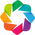

In [2]:
from neurologic import run, plot_statistics, learned_template, display_neural_nets
import holoviews as hv
from IPython.display import display_svg
hv.notebook_extension('bokeh')
%load_ext autoreload
%autoreload 2

In [1]:
%logstart
#output = run("poker_rules.pl","poker_training_set.pl",grounding="sum",**{"learning-rate":"0.1"})
# If the learning phase is done
output = "./outputs/"

Activating auto-logging. Current session state plus future input saved.
Filename       : ipython_log.py
Mode           : rotate
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


The w

# Results: Learning curve

In [ ]:
%%opts Curve [width=725 height=400]
plot_statistics(output)

# Results: Learned template

In [ ]:
print(learned_template(output))

# Results: Neural networks

In [ ]:
display_neural_nets(output)

If you want to explore the how does the template reacts throughout learning, you can use network response tool.

# Network Response

In [3]:
from neurologic import response_visualizer

In [ ]:
%%writefile poker_response.pl
cardFromGroup(Group,0) :- card(0,2,spades),range(RangeGroup,2,5),member(Group,RangeGroup). [^Group]
score() :- card(0,3,hearts),card(0,2,spades),range(RangeGroup,2,5),member(Group,RangeGroup). [^Group]

In [4]:
%%opts Curve [width=725 height=400]
%%opts Points (size=7) Curve (alpha=0.3)
response_visualizer.plot_response("poker_response.pl",output)

:DynamicMap   [Epoch,Restart,Fold]